In [56]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

# Loading Unweighted Networks

['0.0_A.npy', '1.0_A.npy', '2.0_A.npy', '3.0_A.npy']
sum  17632.0
sum  22634.0
sum  15442.0
sum  17598.0


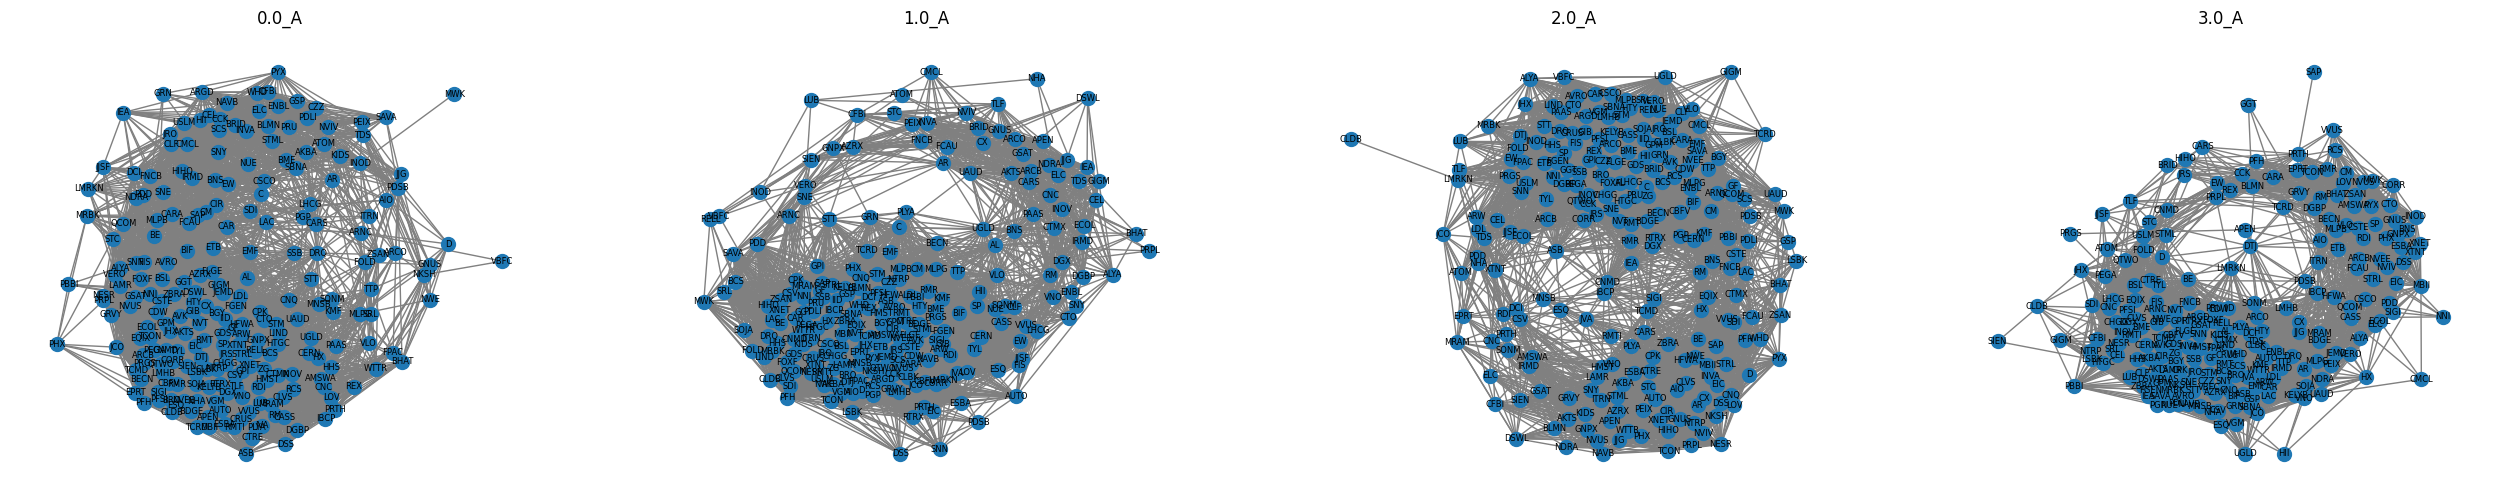

In [57]:
network_files = os.listdir("snapshots")
unweighted_network_files = [s for s in network_files if s.endswith("_A.npy")]
unweighted_network_files.sort(key=lambda x: float(x.split('_')[0]))
print(unweighted_network_files)

samples = len(unweighted_network_files)
domain = np.arange(samples)

unweighted_network_adj_matricies = [np.load(f"snapshots/{n}") for n in unweighted_network_files]

for A in unweighted_network_adj_matricies:
    print("sum ", np.sum(A))

unweighted_networks = [nx.from_numpy_array(A) for A in unweighted_network_adj_matricies]

adj_close_prices = dict(np.load("stock_item_map_small.npz", allow_pickle=True))
key_enum = list(enumerate(adj_close_prices))

labels = {i: key_enum[i][1] for i in range(len(adj_close_prices))}

fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()
for i,G in enumerate(unweighted_networks):
    pos = nx.kamada_kawai_layout(G)
    axes[i].set_title(unweighted_network_files[i][:-4])
    nx.draw(G, pos, labels=labels, with_labels=True, edge_color='gray', node_size=100, font_size=6, ax=axes[i])


# Mean Degree & Degree distribution

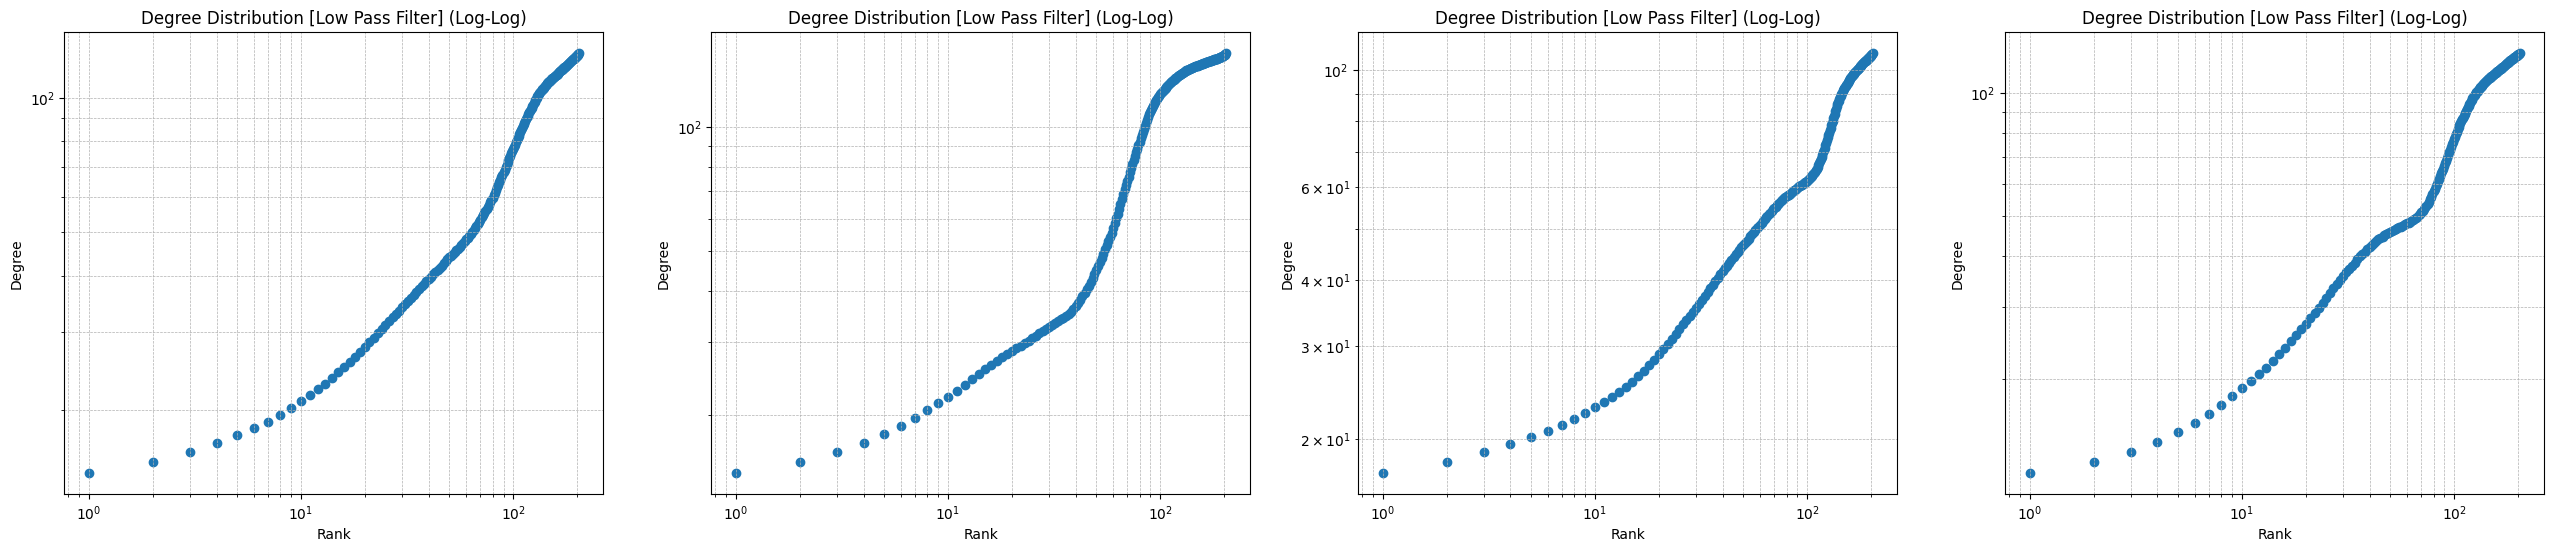

Text(0.5, 1.0, 'mean degree over time')

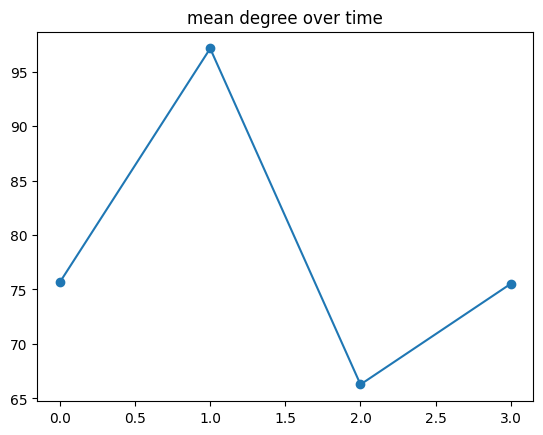

In [58]:
fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

mean_degree_evolution = []

def evaluate_degree_dist(A, i):
    ks = np.sum(A, axis=1)
    ks = np.sort(ks)

    mean_k = np.mean(ks)
    mean_degree_evolution.append(mean_k)

    # Already sorted: ks
    window_size = 30  # You can tune this value

    # apply a low pass filter
    smoothed_ks = np.convolve(ks, np.ones(window_size)/window_size, mode='valid')

    ranks = np.arange(1, len(smoothed_ks)+1)
    axes[i].scatter(ranks, smoothed_ks)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel('Rank')
    axes[i].set_ylabel('Degree')
    axes[i].set_title('Degree Distribution [Low Pass Filter] (Log-Log)')
    axes[i].grid(True, which="both", ls="--", lw=0.5)


for i,A in enumerate(unweighted_network_adj_matricies):
    evaluate_degree_dist(A, i)

plt.show()
plt.scatter(domain, mean_degree_evolution)
plt.plot(domain, mean_degree_evolution)
plt.title("mean degree over time")

# Entropy of Degree Distribution

Text(0.5, 1.0, 'entropy of degree distribution over time')

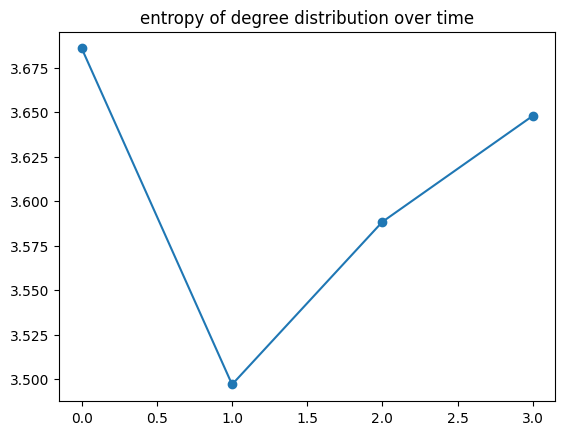

In [59]:
from scipy.stats import entropy

entropy_evolution = []

def evaluate_degree_dist_entropy(A):
    ks = np.sum(A, axis=1)

    hist, bins = np.histogram(ks, bins=50, density=True)
    hist = hist[hist > 0]  # remove zero bins
    degree_entropy = entropy(hist)
    entropy_evolution.append(degree_entropy)

for A in unweighted_network_adj_matricies:
    evaluate_degree_dist_entropy(A)

plt.scatter(domain, entropy_evolution)
plt.plot(domain, entropy_evolution)
plt.title("entropy of degree distribution over time")


# Complementary Cumulative Distribution Function (CCDF)

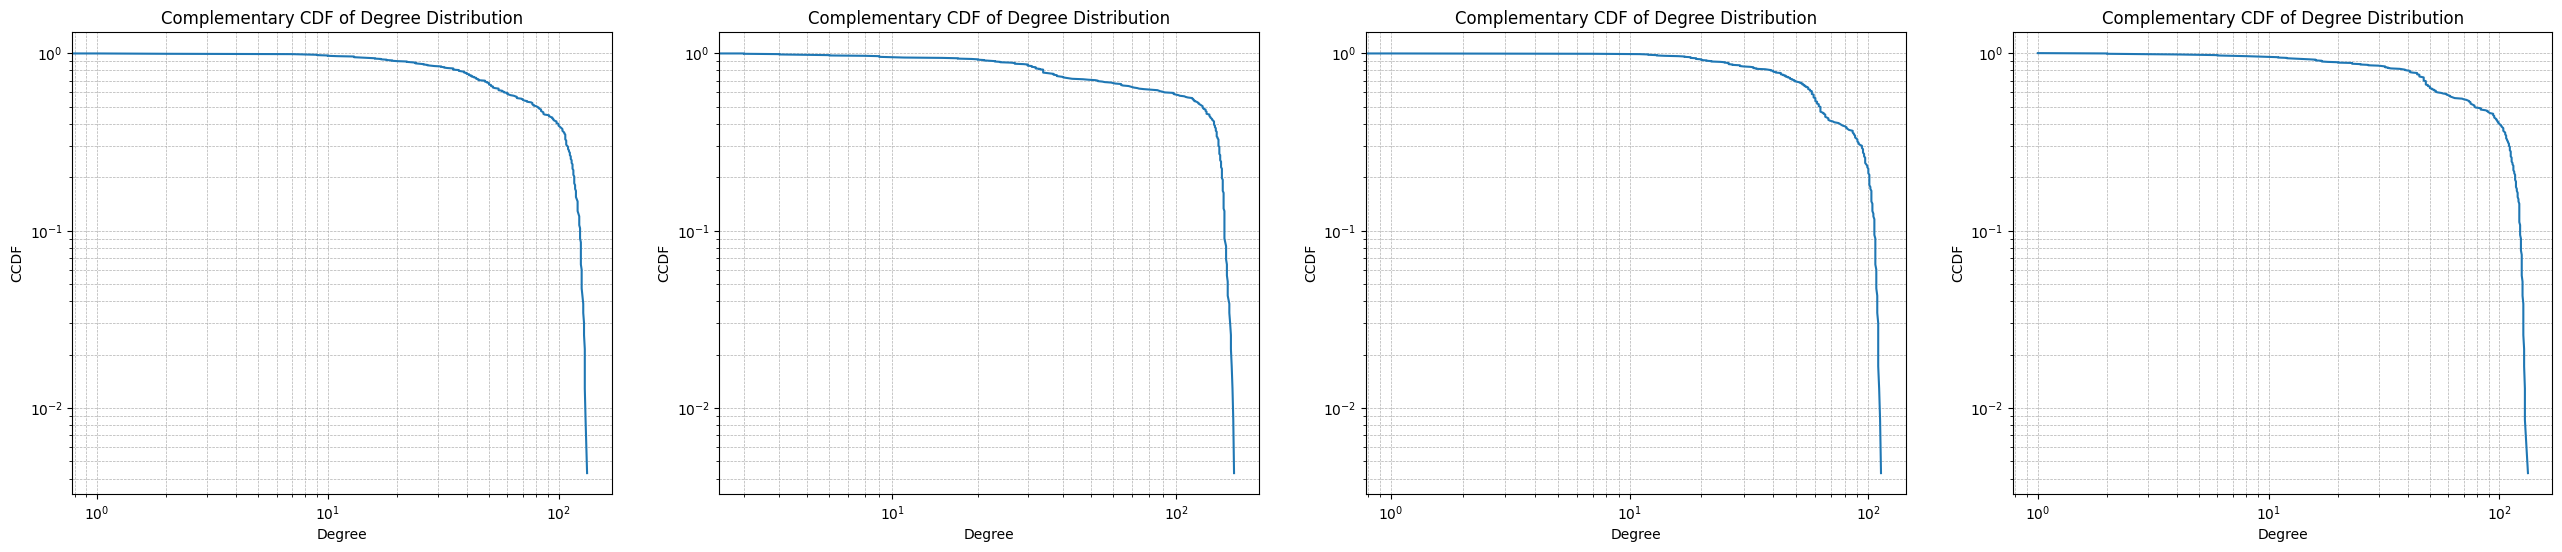

In [60]:
fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

def evaluate_ccdf(A, i):
    ks = np.sum(A, axis=1)
    ks = np.sort(ks)
    ccdf = 1.0 - np.arange(len(ks)) / float(len(ks))

    axes[i].plot(ks, ccdf)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel("Degree")
    axes[i].set_ylabel("CCDF")
    axes[i].set_title("Complementary CDF of Degree Distribution")
    axes[i].grid(True, which="both", ls="--", lw=0.5)

for i,A in enumerate(unweighted_network_adj_matricies):
    evaluate_ccdf(A, i)

# Betweeness Centrality

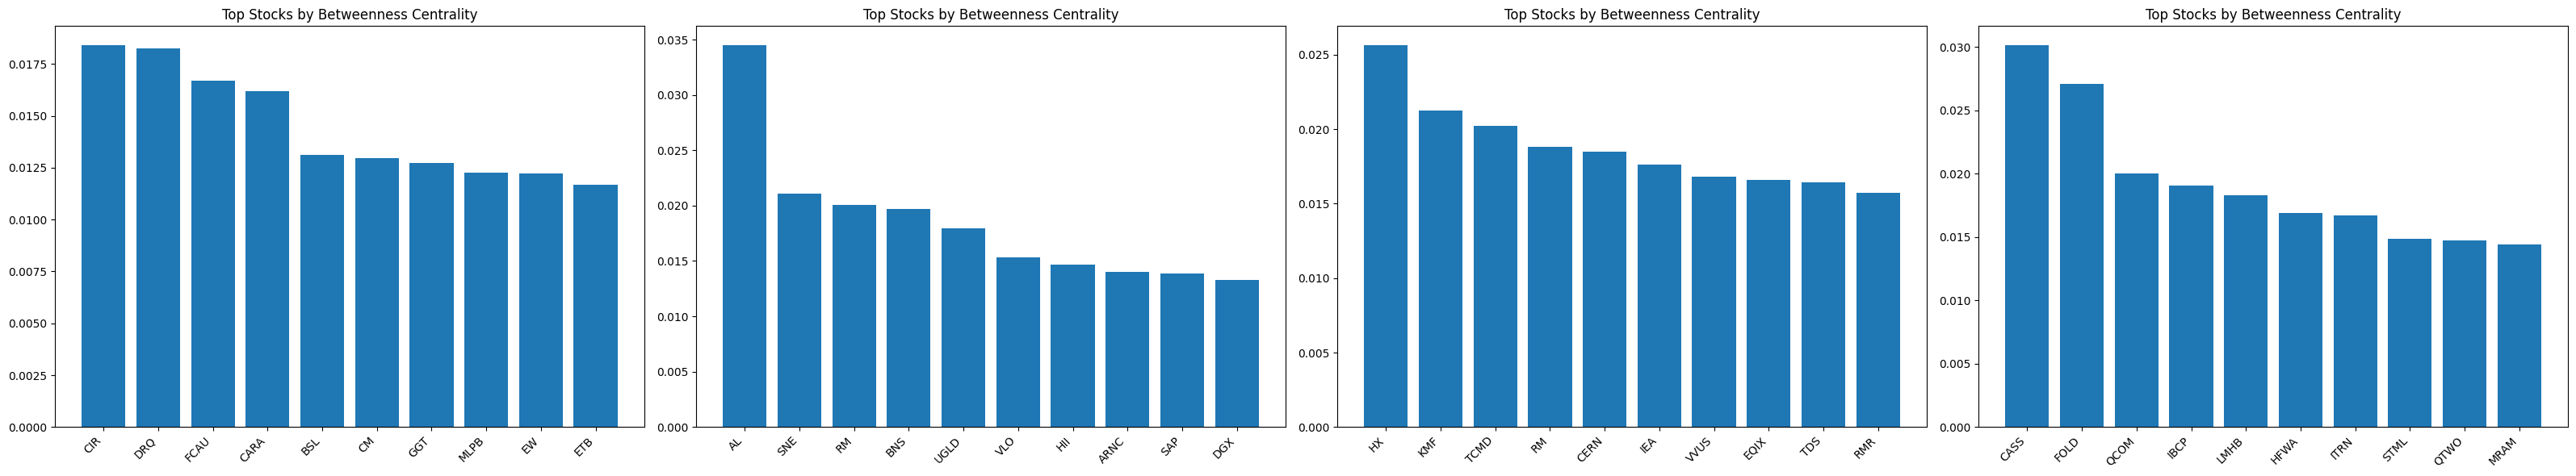

In [61]:
fig, axes = plt.subplots(1, samples, figsize=(8 * samples, 6))
if samples == 1:
    axes = [axes]

def evaluate_betweenness_centrality(G, i):
    betweenness = nx.betweenness_centrality(G)

    top_k = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
    labels = [f"{key_enum[node][1]}" for node, _ in top_k]
    values = [v for _, v in top_k]

    axes[i].bar(labels, values)
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation=45, ha='right')
    axes[i].set_title("Top Stocks by Betweenness Centrality")

for i, G in enumerate(unweighted_networks):
    evaluate_betweenness_centrality(G, i)

fig.tight_layout()
plt.show()


# Global & Local Clustering Coefficient

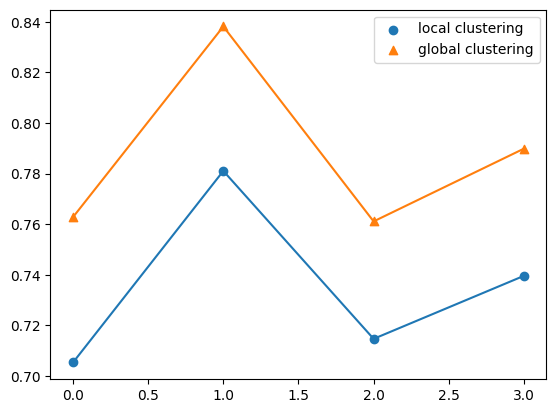

In [62]:
local_cc = []
global_cc = []

def evaluate_clustering_coefficient(G):
    global_clustering = nx.transitivity(G)

    avg_local_clustering = nx.average_clustering(G)

    local_cc.append(avg_local_clustering)
    global_cc.append(global_clustering)

for G in unweighted_networks:
    evaluate_clustering_coefficient(G)

axes = axes.flatten()

plt.scatter(domain, local_cc, label="local clustering")
plt.scatter(domain, global_cc, marker='^', label="global clustering")

plt.plot(domain, local_cc)
plt.plot(domain, global_cc)

plt.legend()

# Eigenvector Clustering With Laplacian Matrix

/tmp/ipykernel_35846/245217729.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("Set1", len(unique_labels))


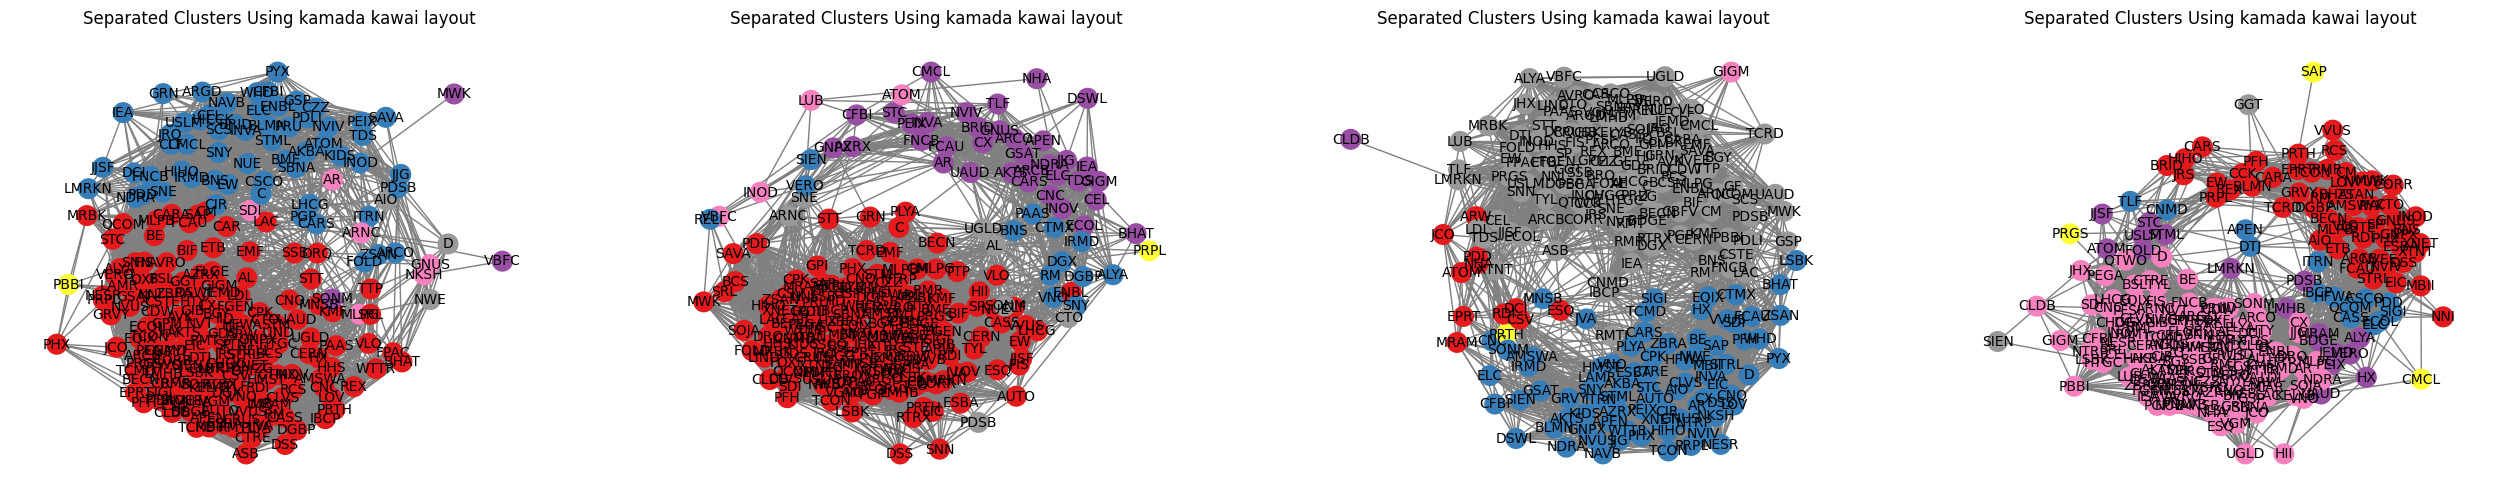

In [63]:
def kmeans(X, k, max_iters=1000, tol=1e-5):
    np.random.seed(42)
    centroids = X[np.random.choice(len(X), k, replace=False)]

    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return labels

fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

def eigenvector_clustering(A, i):
    ks = np.sum(A, axis=1)
    D = np.diag(ks)
    L = D - A
    _, U = np.linalg.eigh(L)

    K = 6
    cluster_labels = kmeans(U[:, 1:K+1], K)
    unique_labels = np.unique(cluster_labels)

    G = nx.from_numpy_array(A)
    color_map = plt.cm.get_cmap("Set1", len(unique_labels))
    node_colors = [color_map(label) for label in cluster_labels]

    cluster_nodes = {k: [] for k in unique_labels}
    for j, label in enumerate(cluster_labels):
        cluster_nodes[label].append(j)

    pos = nx.kamada_kawai_layout(G)

    nx.draw(G, pos=pos, labels=labels, with_labels=True,
            node_color=node_colors, edge_color='grey', node_size=200, font_size=10, ax=axes[i])
    axes[i].set_title("Separated Clusters Using kamada kawai layout")
    axes[i].axis('off')

for i, A in enumerate(unweighted_network_adj_matricies):
    eigenvector_clustering(A, i)

# Community Detection & Modularity With Louvain Algorithm

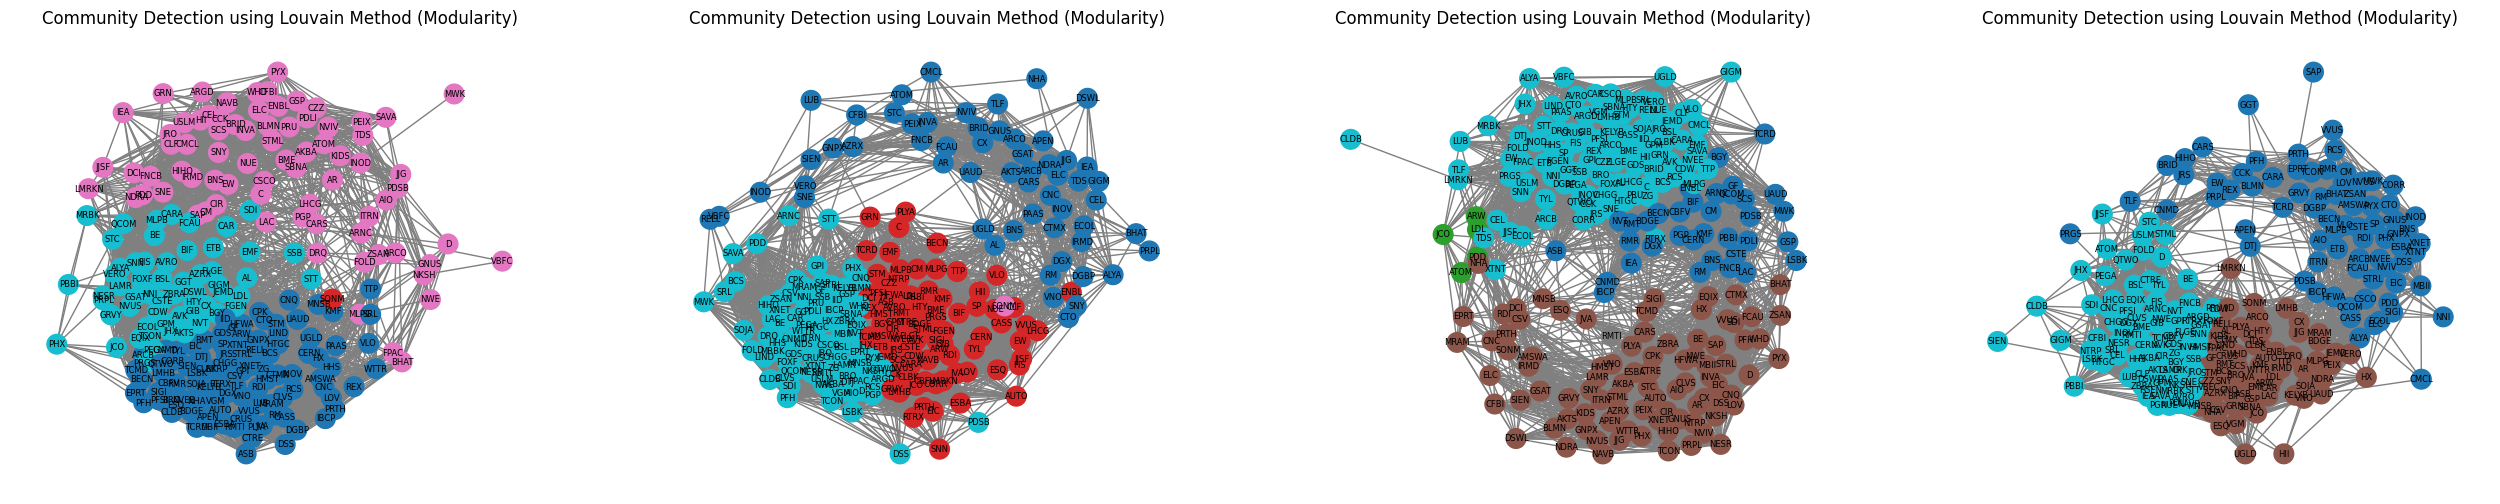

Text(0.5, 1.0, 'modularity over time')

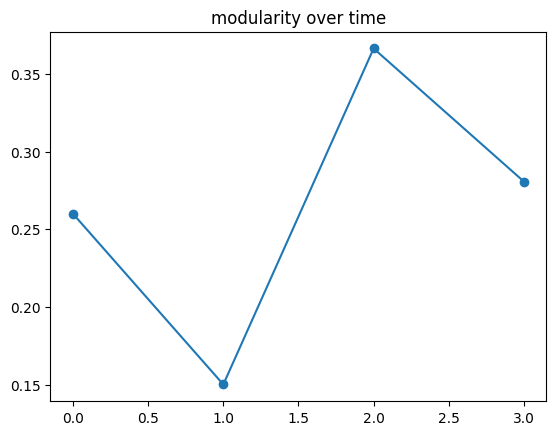

In [64]:
import community as community_louvain

fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

community_evolution = []
modularity_evolution = []

def louvain_community_detection(G, i):

    partition = community_louvain.best_partition(G)

    color_map = {node: partition[node] for node in G.nodes()}

    colors = [color_map[node] for node in G.nodes()]
    pos = nx.kamada_kawai_layout(G) 

    nx.draw(G, pos, labels=labels, node_color=colors, with_labels=True, node_size=200,font_size=6, edge_color='gray', cmap=plt.cm.tab10, ax=axes[i])
    axes[i].set_title("Community Detection using Louvain Method (Modularity)")

    communities = [set() for _ in range(max(partition.values()) + 1)]
    for node, comm in partition.items():
        communities[comm].add(node)

    community_evolution.append(communities)

    mod_score = community_louvain.modularity(partition, G)
    modularity_evolution.append(mod_score)

for i, G in enumerate(unweighted_networks):
    louvain_community_detection(G, i)

plt.show()

plt.scatter(domain, modularity_evolution)
plt.plot(domain, modularity_evolution)
plt.title("modularity over time")

# Loading Weighted Networks

In [65]:
weighted_network_files = [s for s in network_files if s.endswith("_Aw.npy")]
weighted_network_files.sort(key=lambda x: float(x.split('_')[0]))

print(weighted_network_files)

weighted_network_adj_matricies = [np.load(f"snapshots/{n}") for n in weighted_network_files]
weighted_networks = [nx.from_numpy_array(A) for A in weighted_network_adj_matricies]

['0.0_Aw.npy', '1.0_Aw.npy', '2.0_Aw.npy', '3.0_Aw.npy']


# Minimum Spanning Tree on Weighted & Unweighted Networks, Then Apply Louvain Community Detection to the MST

weighted networks


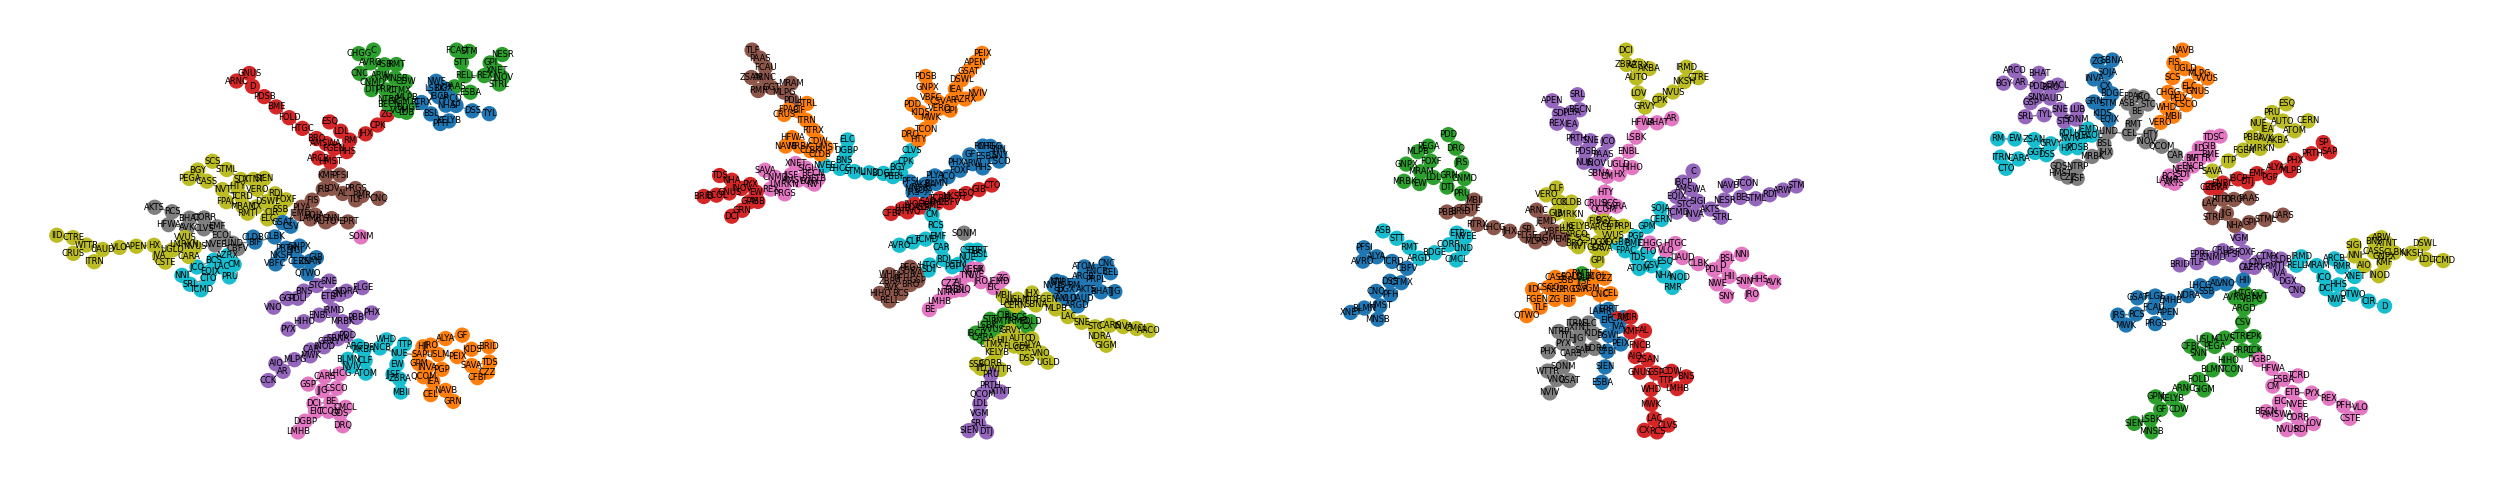

In [75]:
fix, axes = plt.subplots(1, samples, figsize=(8*samples, 6))
axes = axes.flatten()

weighted_msts = []

def evaluate_min_spanning_tree(G, i):
    mst = nx.minimum_spanning_tree(G, weight='weight')
    partition = community_louvain.best_partition(mst)

    color_map = {node: partition[node] for node in mst.nodes()}

    colors = [color_map[node] for node in mst.nodes()]
    pos = nx.kamada_kawai_layout(mst) 
    weighted_msts.append(mst)
    nx.draw(mst, pos, labels=labels, node_color=colors, with_labels=True, node_size=100,font_size=6, edge_color='gray', cmap=plt.cm.tab10, ax=axes[i])

print("weighted networks")
for i, G in enumerate(weighted_networks):
    evaluate_min_spanning_tree(G, i)

# Tracking Community Evolution

In [76]:
from collections import defaultdict

def match_communities(prev_communities, next_communities):
    match = {}
    for next_idx, next_nodes in enumerate(next_communities):
        max_jaccard = 0
        best_match = None
        for prev_idx, prev_nodes in enumerate(prev_communities):
            intersection = len(next_nodes & prev_nodes)
            union = len(next_nodes | prev_nodes)
            jaccard = intersection / union if union else 0
            if jaccard > max_jaccard:
                max_jaccard = jaccard
                best_match = prev_idx
        match[next_idx] = best_match
    return match

for t in range(samples - 1):
    prev = community_evolution[t]
    next_ = community_evolution[t + 1]

    forward = match_communities(prev, next_)
    reverse = match_communities(next_, prev)

    survival = []
    splits = defaultdict(list)
    merges = defaultdict(list)
    births = set(range(len(next_)))
    deaths = set(range(len(prev)))

    for next_idx, prev_idx in forward.items():
        if prev_idx is not None:
            if reverse.get(prev_idx) == next_idx:
                survival.append((prev_idx, next_idx))
                births.discard(next_idx)
                deaths.discard(prev_idx)
            else:
                splits[prev_idx].append(next_idx)
                births.discard(next_idx)
                deaths.discard(prev_idx)

    for prev_idx, next_idx in reverse.items():
        if next_idx is not None and forward.get(next_idx) != prev_idx:
            merges[next_idx].append(prev_idx)

    print(f"\nTime {t} ➝ {t+1}")
    print("  Survival:", survival)
    print("  Splits:", dict(splits))
    print("  Merges:", dict(merges))
    print("  Births:", births)
    print("  Deaths:", deaths)


Time 0 ➝ 1
  Survival: [(2, 0), (0, 1), (1, 2)]
  Splits: {0: [3]}
  Merges: {1: [3]}
  Births: set()
  Deaths: {3}

Time 1 ➝ 2
  Survival: [(1, 4)]
  Splits: {1: [0, 1], 3: [2, 3]}
  Merges: {2: [0, 2], 4: [3]}
  Births: set()
  Deaths: {0, 2}

Time 2 ➝ 3
  Survival: [(2, 0), (4, 2)]
  Splits: {4: [1]}
  Merges: {0: [0], 1: [1], 2: [3]}
  Births: set()
  Deaths: {0, 1, 3}


# Centrality Evolution

# Edge Persistence & Edge Weight Dynamics

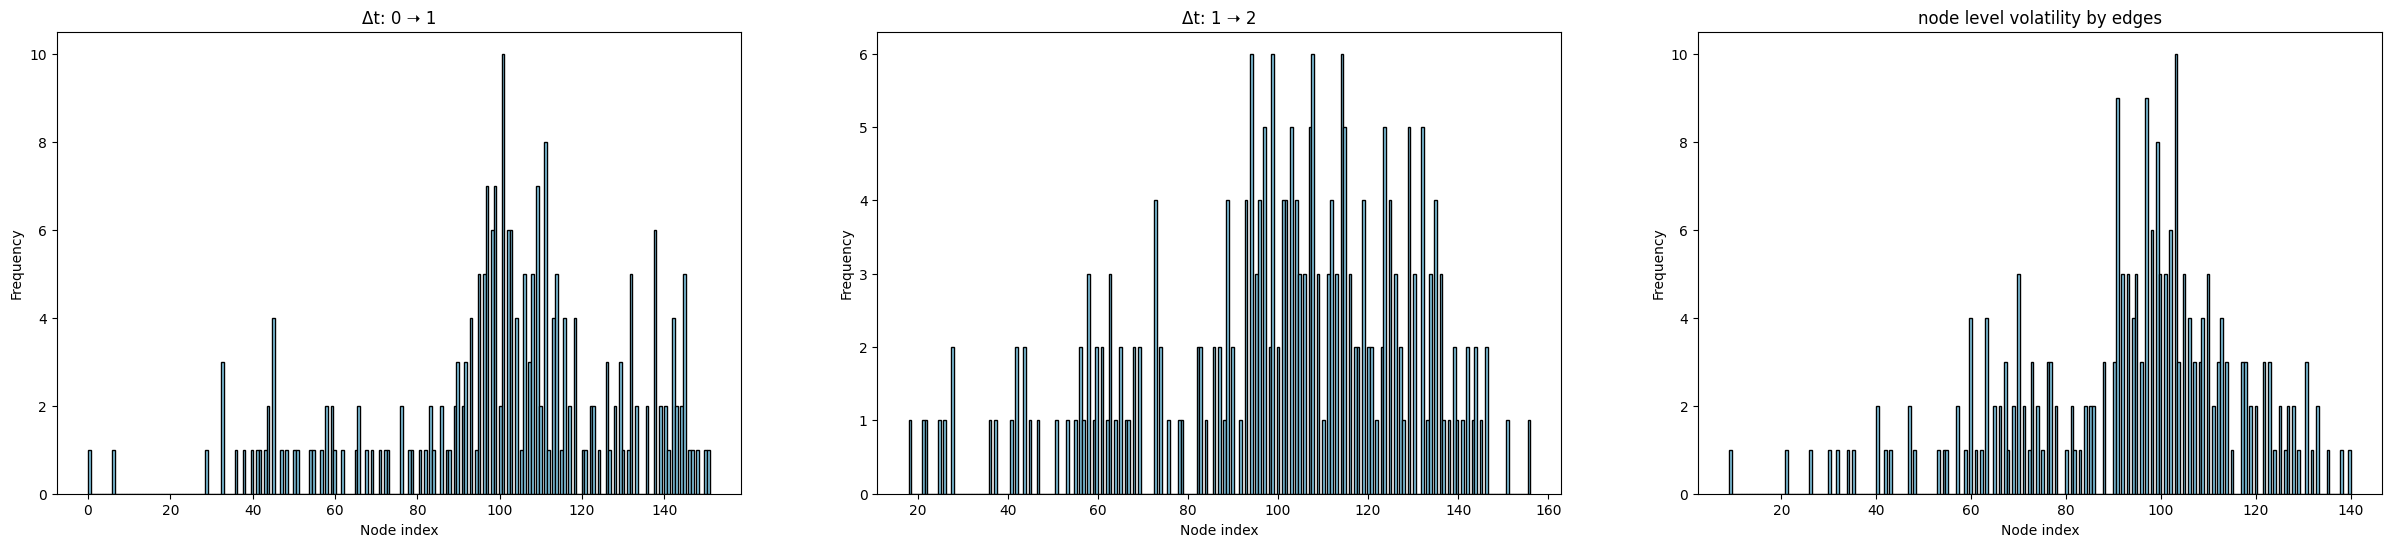

Most stable nodes: [['PDSB', 30.333333333333332], ['ATOM', 31.666666666666668], ['BHAT', 37.0], ['SONM', 37.333333333333336], ['MWK', 46.0], ['ELC', 46.666666666666664], ['PRPL', 52.333333333333336], ['CARS', 56.0], ['VBFC', 56.666666666666664], ['CFBI', 58.0]]
Most volatile nodes: [['FPAC', 131.0], ['MNSB', 131.33333333333334], ['DCI', 132.0], ['WTTR', 132.66666666666666], ['GSP', 133.33333333333334], ['NKSH', 133.66666666666666], ['CIR', 137.0], ['NAVB', 138.0], ['WHD', 138.0], ['KIDS', 139.33333333333334]]


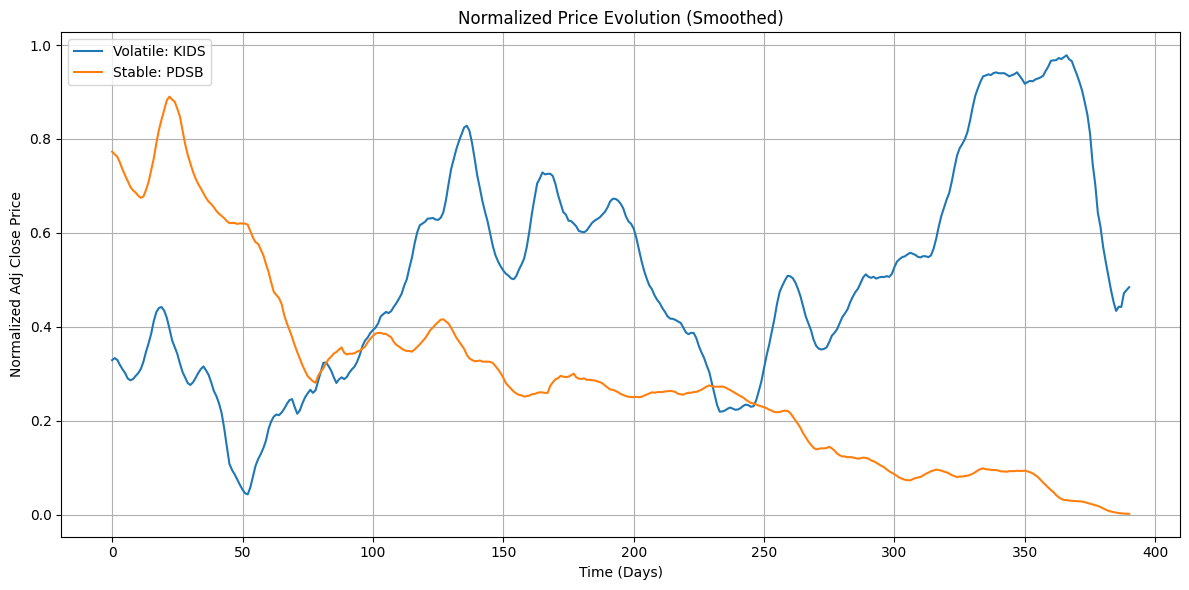

In [77]:
import pandas as pd

def time_differential(A1, A2):
    return np.abs(np.subtract(A1, A2)).sum(axis=1)

fix, axes = plt.subplots(1, samples-1, figsize=(10*(samples-1), 6))
axes = axes.flatten()

node_time_deltas = []

for i in range(samples -1):
    A1 = unweighted_network_adj_matricies[i]
    A2 = unweighted_network_adj_matricies[i+1]

    delta_t = time_differential(A1, A2)
    node_time_deltas.append(delta_t)

    axes[i].hist(delta_t, bins=len(A1), color='skyblue', edgecolor='black')
    axes[i].set_title(f"Δt: {i} ➝ {i+1}")
    axes[i].set_xlabel("Node index")
    axes[i].set_ylabel("Frequency")

plt.title("node level volatility by edges")
fig.tight_layout()
plt.show()

node_time_deltas = np.array(node_time_deltas)
avg_volatility = node_time_deltas.mean(axis=0)
volatility_ranking = np.argsort(avg_volatility)

most_stable = volatility_ranking[:10]
most_volatile = volatility_ranking[-10:]

print("Most stable nodes:", [[key_enum[n][1], float(avg_volatility[n])] for n in volatility_ranking[:10]])
print("Most volatile nodes:", [[key_enum[n][1], float(avg_volatility[n])] for n in volatility_ranking[-10:]])

rolling_window = 10

least_stable_item = pd.Series(adj_close_prices[key_enum[most_volatile[-1]][1]])
most_stable_item = pd.Series(adj_close_prices[key_enum[most_stable[0]][1]])

least_stable_norm = (least_stable_item - least_stable_item.min()) / (least_stable_item.max() - least_stable_item.min())
most_stable_norm = (most_stable_item - most_stable_item.min()) / (most_stable_item.max() - most_stable_item.min())

least_stable_smoothed = least_stable_norm.rolling(rolling_window).mean().dropna()
most_stable_smoothed = most_stable_norm.rolling(rolling_window).mean().dropna()

domain = np.arange(len(least_stable_smoothed))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(domain, least_stable_smoothed, label=f"Volatile: {key_enum[most_volatile[-1]][1]}")
plt.plot(domain, most_stable_smoothed, label=f"Stable: {key_enum[most_stable[0]][1]}")
plt.title("Normalized Price Evolution (Smoothed)")
plt.xlabel("Time (Days)")
plt.ylabel("Normalized Adj Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



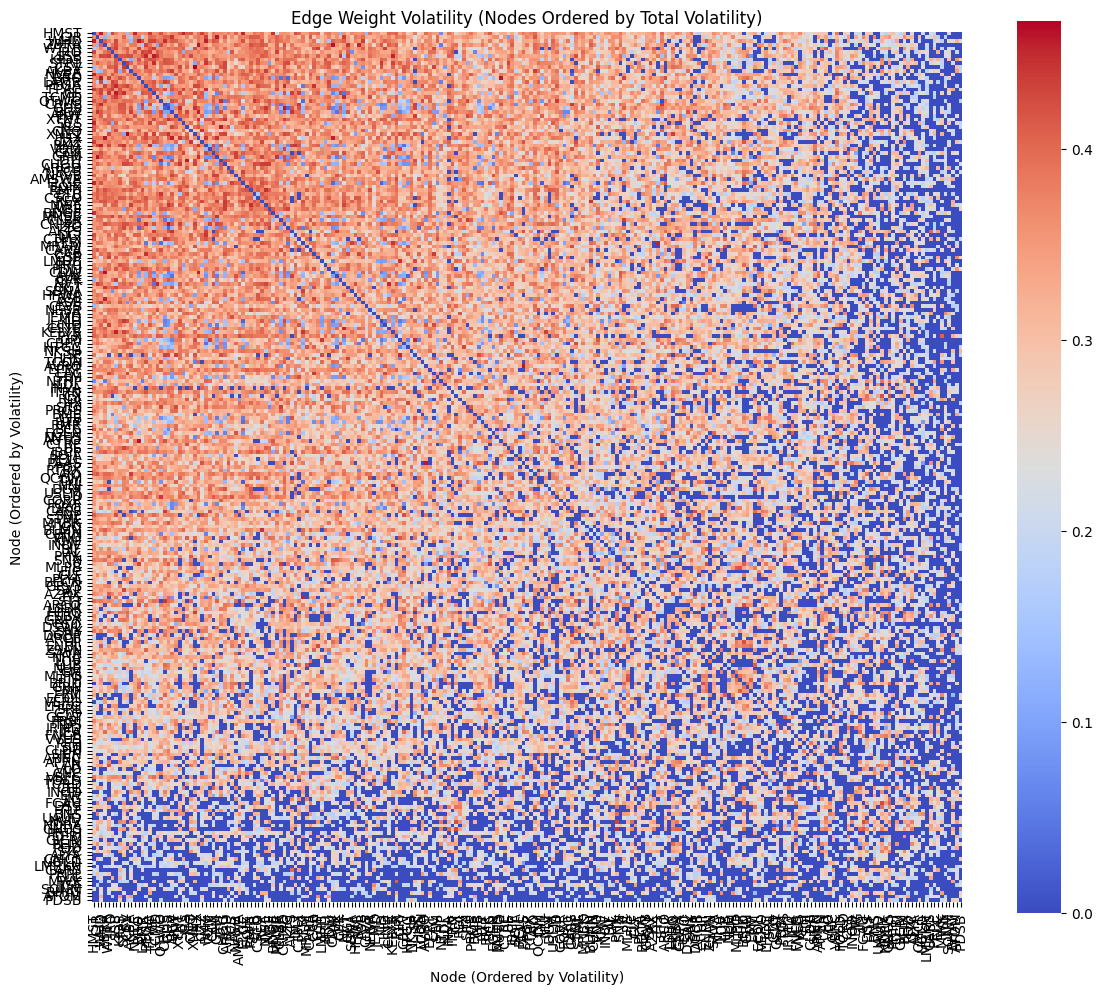

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

W = np.stack(weighted_network_adj_matricies)
edge_volatility = np.std(W, axis=0)

node_volatility = edge_volatility.sum(axis=0) + edge_volatility.sum(axis=1)

ordered_indices = np.argsort(-node_volatility)

reordered_volatility = edge_volatility[np.ix_(ordered_indices, ordered_indices)]

ordered_labels = [key_enum[i][1] for i in ordered_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(reordered_volatility, cmap='coolwarm', square=True, 
            xticklabels=ordered_labels, yticklabels=ordered_labels)

plt.title("Edge Weight Volatility (Nodes Ordered by Total Volatility)")
plt.xlabel("Node (Ordered by Volatility)")
plt.ylabel("Node (Ordered by Volatility)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Volatility Forecasting

In [81]:
import networkx as nx

def extract_mst_features(G):
    features = {}
    degrees = dict(G.degree())
    
    features['mean_degree'] = np.mean(list(degrees.values()))
    features['std_degree'] = np.std(list(degrees.values()))
    features['mst_weight'] = G.size(weight='weight')
    
    # Centralities
    degree = nx.degree_centrality(G)
    features['degree_std'] = np.std(list(degree.values()))
    
    betw = nx.betweenness_centrality(G, weight='weight')
    features['betweenness_max'] = np.max(list(betw.values()))
    
    return features

all_features = []
for mst in weighted_msts:
    features = extract_mst_features(mst)
    all_features.append(features)

print(all_features)

[{'mean_degree': np.float64(1.9828326180257512), 'std_degree': np.float64(1.3166665714581243), 'mst_weight': 94.12464820730347, 'degree_std': np.float64(0.0056752869459401915), 'betweenness_max': np.float64(0.623787132407822)}, {'mean_degree': np.float64(1.9828326180257512), 'std_degree': np.float64(1.3360812124710228), 'mst_weight': 94.28883318605683, 'degree_std': np.float64(0.005758970743409582), 'betweenness_max': np.float64(0.5528437080161218)}, {'mean_degree': np.float64(1.9828326180257512), 'std_degree': np.float64(1.1570484324295014), 'mst_weight': 94.26162043546282, 'degree_std': np.float64(0.004987277725989231), 'betweenness_max': np.float64(0.7502985520226899)}, {'mean_degree': np.float64(1.9914163090128756), 'std_degree': np.float64(1.1682179536378592), 'mst_weight': 94.93220302721312, 'degree_std': np.float64(0.00503542221395629), 'betweenness_max': np.float64(0.5771383788625167)}]


https://www.sciencedirect.com/science/article/abs/pii/S0167947304000258

https://arxiv.org/abs/1501.05040